<center><h1>Domain Adaptation</h1></center>

<center><h2><a href="https://arthurdouillard.com/deepcourse/">Course link</a></h2></center>

To keep your modifications in case you want to come back later to this colab, do *File -> Save a copy in Drive*.

We will implement the paper **Unsupervised Domain Adaptation by Backpropagation** in this session. We strongly advise to read this paper, it's a major one!

https://arxiv.org/abs/1409.7495

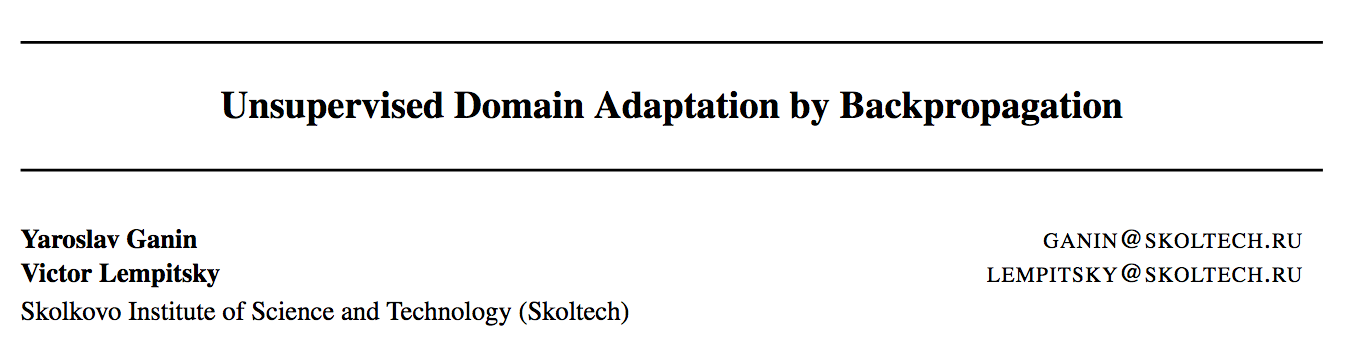

In [ ]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image

We are going to do a **domain adaptation** from a source dataset (MNIST) towards a target dataset (MNIST-M).

First, we need to create the target dataset:

In [ ]:
!wget https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py

--2022-01-15 11:28:36--  https://raw.githubusercontent.com/rdfia/rdfia.github.io/master/code/3-c/mnistm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2659 (2.6K) [text/plain]
Saving to: ‘mnistm.py’

mnistm.py           100%[===================>]   2.60K  --.-KB/s    in 0s      

2022-01-15 11:28:36 (58.4 MB/s) - ‘mnistm.py’ saved [2659/2659]



In [ ]:
from mnistm import create_mnistm

create_mnistm()

Creating MNIST-M... That may takes a minute
Loading BSR training images


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw

Building train set...
Processing example 0


/content/mnistm.py:45: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  bg_img = rand.choice(background_data)


Processing example 10000
Processing example 20000
Processing example 30000
Processing example 40000
Processing example 50000
Building test set...
Processing example 0
Done!


Then, let's load the MNIST dataset and compute its (train!) mean and standard deviation.

We will use those values to **standardize** both MNIST and MNIST-M.

In [ ]:
mnist_pixels = torchvision.datasets.MNIST('.', train=True, download=True).data / 255
mean = mnist_pixels.mean().item()
std = mnist_pixels.std().item()

print(f"Mean {mean} and Std {std}")
mean = torch.tensor([mean, mean, mean])
std = torch.tensor([std, std, std])

Mean 0.13066047430038452 and Std 0.30810782313346863


Create the loaders for MNIST...

In [ ]:
transform = transforms.Compose([
  transforms.ToTensor(),
  lambda x: x.repeat(3, 1, 1) if x.shape[0] == 1 else x,
  transforms.Normalize(mean, std)
])

mnist_train = torchvision.datasets.MNIST('.', train=True, transform=transform)
mnist_test = torchvision.datasets.MNIST('.', train=False, transform=transform)

source_train_loader = DataLoader(mnist_train, batch_size=128)
source_test_loader = DataLoader(mnist_test, batch_size=128)

... and visualize!

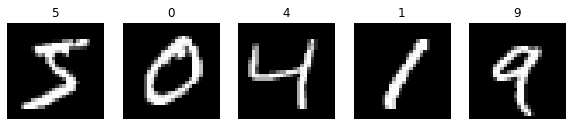

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnist_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8), cmap='gray')
  plt.title(y)

Likewise, for MNIST-M. We create a simple `Dataset` in order to load the dataset that was serialized as a pickle:

In [ ]:
with open('mnistm_data.pkl', 'rb') as f:
  mnist_m = pickle.load(f)

class MNISTM(torch.utils.data.Dataset):
  def __init__(self, x, y, transform):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

mnistm_train = MNISTM(mnist_m["x_train"], mnist_m["y_train"], transform)
mnistm_test = MNISTM(mnist_m["x_test"], mnist_m["y_test"], transform)

target_train_loader = DataLoader(mnistm_train, batch_size=128)
target_test_loader = DataLoader(mnistm_test, batch_size=128)

And we also visualize it. Remember to always visualize your data before training a model on it. You may realize that the dataset is ill-formated, in its pixels or targets, and have to do more data preparation beforehand.

Noice that **MNIST-M** is extremely similar to MNIST. The only difference is that the former has colors and textures, and is thus a RGB image. Because MNIST is in grayscale, we have duplicated thrice its channels axis.

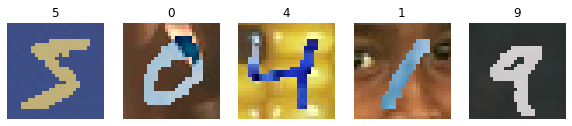

In [ ]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = mnistm_train[i]
  img = ((x * std[:, None, None] + mean[:, None, None]) * 255).permute(1, 2, 0)
  plt.imshow(img.numpy().astype(np.uint8))
  plt.title(y)

Now, let's implement this basic network, whose figure is extracted from the paper. Conceive your model so that convolutions do not reduce the spatial dimensions:

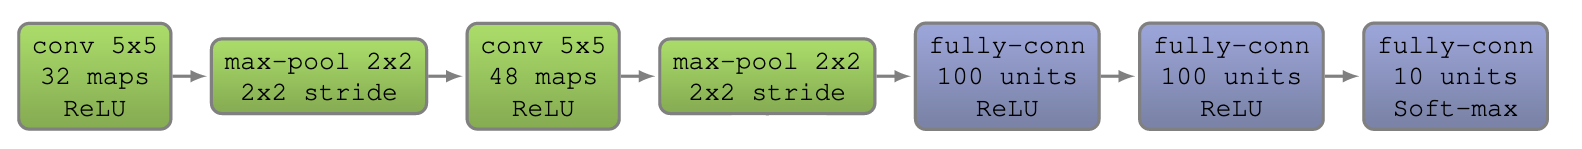

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, padding=2),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2, stride=2),
                             nn.Conv2d(32, 48, kernel_size=5, padding=2),
                             nn.ReLU()
                             nn.MaxPool2d(kernel_size=2, stride=2),
                            ) # TODO

    self.classif = nn.Sequential(nn.Linear(7*7*48, 100),
                                 nn.ReLU(),
                                 nn.Linear(100, 100),
                                 nn.ReLU(),
                                 nn.Linear(100, 10),
                                 nn.Softmax()
                            ) # TODO

  def forward(self, x):
    x = self.cnn(x)
    x = x.reshape(x.shape[0], -1)
    # print(x.shape)
    # print(x.flatten().shape)
    x = self.classif(x)
    # TODO
    return x


NaiveNet().to(device)(torch.randn(2, 3, 28, 28).to(device)).shape

cuda


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


torch.Size([2, 10])

In [ ]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

Let's train our naive model, but only the source (MNIST) dataset. We will evaluate its performance on the target (MNIST-M) dataset afterwards.

Notice that we use a **learning rate scheduler**. We are updating the learning rate after each epoch according to a function defined with a *lambda* following the paper specification. 

We set the initial learning rate to 1.0 because `LambdaLR` defines a *multiplicative factor* of the base learning rate.

It's often useful to reduce likewise the learning rate during training, to facilitate convergence once the model has found a good local minima (we rarely find the global).

In [ ]:
epochs = 50
from tqdm import tqdm

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)

for epoch in tqdm(range(epochs)):
  train_loss = 0.

  for x, y in source_train_loader:
    x, y = x.cuda(), y.cuda()

    optimizer.zero_grad()
    logits = naive_net(x)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
  2%|▏         | 1/50 [00:10<08:55, 10.93s/it]

Epoch 0, train loss: 1.78636
	Learning rate = 0.008721959494934213


  4%|▍         | 2/50 [00:21<08:40, 10.85s/it]

Epoch 1, train loss: 1.58212
	Learning rate = 0.007769695042409124


  6%|▌         | 3/50 [00:32<08:36, 10.98s/it]

Epoch 2, train loss: 1.54174
	Learning rate = 0.007029266564879363


  8%|▊         | 4/50 [00:44<08:28, 11.06s/it]

Epoch 3, train loss: 1.48389
	Learning rate = 0.006434956584934828


 10%|█         | 5/50 [00:54<08:15, 11.02s/it]

Epoch 4, train loss: 1.47925
	Learning rate = 0.005946035575013606


 12%|█▏        | 6/50 [01:05<08:00, 10.93s/it]

Epoch 5, train loss: 1.47598
	Learning rate = 0.005535833116504121


 14%|█▍        | 7/50 [01:16<07:47, 10.87s/it]

Epoch 6, train loss: 1.47386
	Learning rate = 0.005186108144070653


 16%|█▌        | 8/50 [01:27<07:37, 10.90s/it]

Epoch 7, train loss: 1.47249
	Learning rate = 0.004883936278745637


 18%|█▊        | 9/50 [01:38<07:28, 10.94s/it]

Epoch 8, train loss: 1.47129
	Learning rate = 0.004619888312917149


 20%|██        | 10/50 [01:49<07:17, 10.93s/it]

Epoch 9, train loss: 1.47004
	Learning rate = 0.004386913376508308


 22%|██▏       | 11/50 [02:00<07:06, 10.95s/it]

Epoch 10, train loss: 1.46946
	Learning rate = 0.004179626906102637


 24%|██▍       | 12/50 [02:11<06:59, 11.05s/it]

Epoch 11, train loss: 1.46875
	Learning rate = 0.0039938413785795416


 26%|██▌       | 13/50 [02:22<06:51, 11.12s/it]

Epoch 12, train loss: 1.46833
	Learning rate = 0.0038262480777690546


 28%|██▊       | 14/50 [02:33<06:39, 11.09s/it]

Epoch 13, train loss: 1.46771
	Learning rate = 0.0036741958520219342


 30%|███       | 15/50 [02:44<06:25, 11.00s/it]

Epoch 14, train loss: 1.4674
	Learning rate = 0.0035355339059327372


 32%|███▏      | 16/50 [02:55<06:12, 10.95s/it]

Epoch 15, train loss: 1.46702
	Learning rate = 0.0034084979112934868


 34%|███▍      | 17/50 [03:06<05:59, 10.91s/it]

Epoch 16, train loss: 1.46671
	Learning rate = 0.003291626064807194


 36%|███▌      | 18/50 [03:17<05:47, 10.87s/it]

Epoch 17, train loss: 1.46643
	Learning rate = 0.00318369625258112


 38%|███▊      | 19/50 [03:28<05:36, 10.86s/it]

Epoch 18, train loss: 1.46629
	Learning rate = 0.0030836783520511884


 40%|████      | 20/50 [03:38<05:24, 10.81s/it]

Epoch 19, train loss: 1.46607
	Learning rate = 0.002990697562442441


 42%|████▏     | 21/50 [03:49<05:13, 10.80s/it]

Epoch 20, train loss: 1.46587
	Learning rate = 0.002904005885952112


 44%|████▍     | 22/50 [04:00<05:01, 10.78s/it]

Epoch 21, train loss: 1.46576
	Learning rate = 0.0028229597119700817


 46%|████▌     | 23/50 [04:10<04:50, 10.74s/it]

Epoch 22, train loss: 1.46563
	Learning rate = 0.0027470020261194956


 48%|████▊     | 24/50 [04:21<04:39, 10.76s/it]

Epoch 23, train loss: 1.46548
	Learning rate = 0.00267564816275228


 50%|█████     | 25/50 [04:32<04:29, 10.78s/it]

Epoch 24, train loss: 1.46539
	Learning rate = 0.0026084743001221454


 52%|█████▏    | 26/50 [04:43<04:18, 10.76s/it]

Epoch 25, train loss: 1.46527
	Learning rate = 0.0025451080985067548


 54%|█████▍    | 27/50 [04:54<04:07, 10.77s/it]

Epoch 26, train loss: 1.46518
	Learning rate = 0.0024852210273970336


 56%|█████▌    | 28/50 [05:04<03:56, 10.74s/it]

Epoch 27, train loss: 1.4651
	Learning rate = 0.0024285220348909606


 58%|█████▊    | 29/50 [05:15<03:45, 10.73s/it]

Epoch 28, train loss: 1.46503
	Learning rate = 0.0023747522917995333


 60%|██████    | 30/50 [05:26<03:34, 10.73s/it]

Epoch 29, train loss: 1.46498
	Learning rate = 0.002323680802425408


 62%|██████▏   | 31/50 [05:36<03:24, 10.75s/it]

Epoch 30, train loss: 1.4649
	Learning rate = 0.002275100718924222


 64%|██████▍   | 32/50 [05:47<03:12, 10.71s/it]

Epoch 31, train loss: 1.46484
	Learning rate = 0.0022288262304402963


 66%|██████▌   | 33/50 [05:58<03:01, 10.69s/it]

Epoch 32, train loss: 1.46478
	Learning rate = 0.002184689924568985


 68%|██████▊   | 34/50 [06:08<02:50, 10.69s/it]

Epoch 33, train loss: 1.46474
	Learning rate = 0.002142540539124344


 70%|███████   | 35/50 [06:19<02:40, 10.69s/it]

Epoch 34, train loss: 1.4647
	Learning rate = 0.0021022410381342864


 72%|███████▏  | 36/50 [06:30<02:29, 10.67s/it]

Epoch 35, train loss: 1.46466
	Learning rate = 0.00206366695851539


 74%|███████▍  | 37/50 [06:40<02:19, 10.71s/it]

Epoch 36, train loss: 1.46464
	Learning rate = 0.002026704983791064


 76%|███████▌  | 38/50 [06:51<02:08, 10.72s/it]

Epoch 37, train loss: 1.46461
	Learning rate = 0.0019912517091052


 78%|███████▊  | 39/50 [07:02<01:57, 10.70s/it]

Epoch 38, train loss: 1.46457
	Learning rate = 0.0019572125680985615


 80%|████████  | 40/50 [07:12<01:46, 10.68s/it]

Epoch 39, train loss: 1.46455
	Learning rate = 0.0019245008972987524


 82%|████████▏ | 41/50 [07:23<01:36, 10.70s/it]

Epoch 40, train loss: 1.46453
	Learning rate = 0.0018930371177884838


 84%|████████▍ | 42/50 [07:34<01:25, 10.72s/it]

Epoch 41, train loss: 1.46451
	Learning rate = 0.0018627480172627167


 86%|████████▌ | 43/50 [07:45<01:14, 10.71s/it]

Epoch 42, train loss: 1.46449
	Learning rate = 0.0018335661183195697


 88%|████████▊ | 44/50 [07:55<01:04, 10.70s/it]

Epoch 43, train loss: 1.46448
	Learning rate = 0.0018054291210745947


 90%|█████████ | 45/50 [08:06<00:53, 10.70s/it]

Epoch 44, train loss: 1.46447
	Learning rate = 0.0017782794100389228


 92%|█████████▏| 46/50 [08:17<00:42, 10.68s/it]

Epoch 45, train loss: 1.46446
	Learning rate = 0.0017520636167342972


 94%|█████████▍| 47/50 [08:27<00:32, 10.68s/it]

Epoch 46, train loss: 1.46445
	Learning rate = 0.001726732230792016


 96%|█████████▌| 48/50 [08:38<00:21, 10.67s/it]

Epoch 47, train loss: 1.46443
	Learning rate = 0.00170223925334597


 98%|█████████▊| 49/50 [08:49<00:10, 10.68s/it]

Epoch 48, train loss: 1.46442
	Learning rate = 0.0016785418874204266


100%|██████████| 50/50 [08:59<00:00, 10.80s/it]

Epoch 49, train loss: 1.4644
	Learning rate = 0.0016556002607617019


Test loss: 1.46948, test acc: 99.16


Performance onn less than 10 epochs are great on MNIST, more than 99% accuracy! But this dataset is quite easy.

Now, the real question is: can our model generalize on the slightly different domain of MNIST-M?

In [ ]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Test loss: 1.94002, test acc: 51.24


No... You should have an accuracy of 53 to 57%, far less than the 99% we had.

We are going to implement **DANN**, the **Domain Adverserial Neural Network**. The key part of this network is its domain prediction branch and its **gradient reversal layer** (GRL).

The GRL will reverse the gradient between the domain classifier (in pink) and the features extractor (in green).

What does it mean intuitively? The gradient of the domain classifier should help to better classify the domain. Therefore if we reverse it before the end of the features extractor, we will force this CNN to do the opposite: to make the features as agnostic as possible from the domain. Which would mean that the features of MNIST and MNIST-M will be similar and only the digit info will be kept.

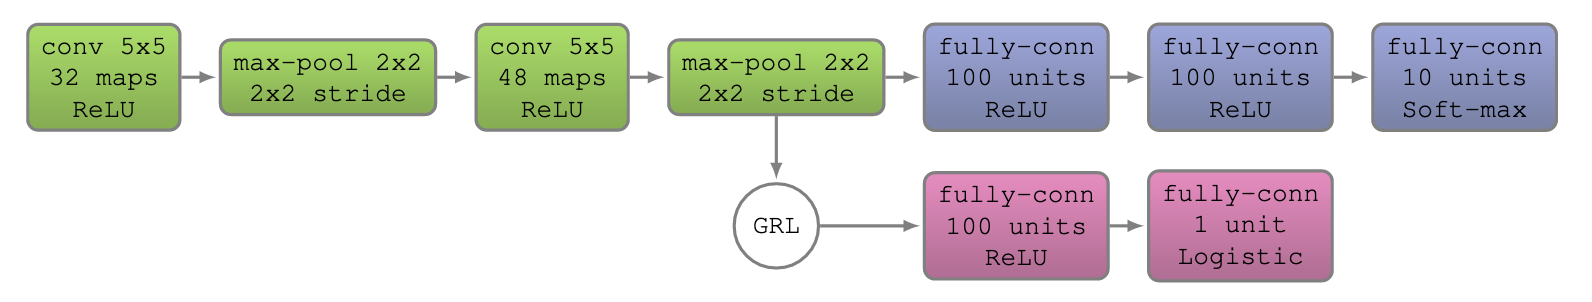

To code a custom backward in PyTorch, you need to define a `torch.autograd.Function`.

The forward is easy, we do nothing except storing a factor that we will need in the backward pass.

In the backward pass we need to return as much gradients as there are inputs (here two). Because the factor is not something to be optimized, we return `None`.

Now, given the factor (which is defaulted to -1, aka "reverse"), define the modified gradient:



In [ ]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    reversed_grad = factor * grad# TODO

    return reversed_grad, None

In [ ]:
x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = x * y
o.backward()
print(x.grad.item())

x = torch.tensor([42.], requires_grad=True)
y = torch.tensor([1337.], requires_grad=True)
o = GradientReversal.apply(x * y, -1)
o.backward()
print(x.grad.item())

1337.0
-1337.0


To use a PyTorch's `Function`, call its apply 

Now, code the DANN. You can re-use parts of the code you wrote for the naive model.

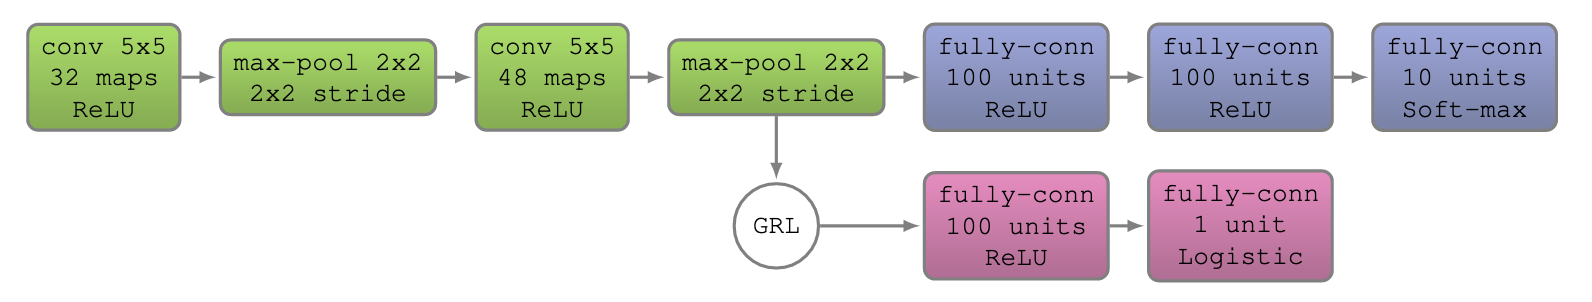

In [ ]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    self.cnn = nn.Sequential(nn.Conv2d(3, 32, kernel_size=5, padding=2),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2, stride=2),
                             nn.Conv2d(32, 48, kernel_size=5, padding=2),
                             nn.ReLU(),
                             nn.MaxPool2d(kernel_size=2, stride=2)
                            ) # TODO

    self.classif = nn.Sequential(nn.Linear(7*7*48, 100),
                                 nn.ReLU(),
                                 nn.Linear(100, 100),
                                 nn.ReLU(),
                                 nn.Linear(100, 10),
                                 nn.Softmax()
                            ) # TODO

    self.domain =  nn.Sequential(nn.Linear(7*7*48, 100),
                                 nn.ReLU(),
                                 nn.Linear(100, 1),
                                 nn.Sigmoid())

  def forward(self, x, factor=-1):
    # TODO
    x = self.cnn(x)
    x = x.reshape(x.shape[0], -1)
    
    class_pred = self.classif(x)
    domain_pred = GradientReversal.apply(self.domain(x), factor)
    return class_pred, domain_pred


NameError: ignored

In [ ]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((torch.sigmoid(domain_logits[:, 0]) > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [ ]:
source_train_loader = DataLoader(mnist_train, batch_size=64)
target_train_loader = DataLoader(mnistm_train, batch_size=64)

len(source_train_loader), len(target_train_loader)

(938, 938)

For the GRL, using directly a factor -1 will results in very bad performance. Therefore we are going to grow the factor gradually during training (deep learning is an art!).

Here is a plot of the function we will use (note that it is a modified version from the paper):

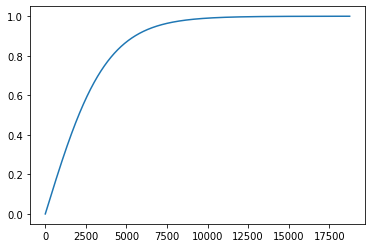

In [ ]:
nb_iters = (len(source_train_loader) * epochs)

x = [i for i in range(nb_iters)]
lmbd = lambda e: -1 + 2 / (1 + math.exp(-10 * e / nb_iters))
y = [lmbd(i) for i in x]

plt.plot(x, y)


Let's train our DANN. The GRL factor will be updated after each batch.

Remember that we are not allowed to use the labels of MNIST-M as we assume this dataset is **unlabeled**.

In [ ]:
epochs = 100

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=1.0, momentum=0.9)

mu0, alpha, beta = 0.01, 10, 0.75
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
)
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in tqdm(range(epochs)):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = F.cross_entropy(cls_logits[:len(ys)], ys)

    domains = torch.cat((torch.ones(len(ys)), torch.zeros(len(xt)))).reshape(domain_logits.shape).cuda()
    bce = F.binary_cross_entropy_with_logits(domain_logits, domains)
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += ce.item()
    domain_loss += bce.item()

  cls_loss = round(cls_loss / len(source_train_loader), 5)
  domain_loss = round(domain_loss / (2 * len(source_train_loader)), 5)
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

NameError: ignored

We should see a huge gain, from the ~55% of accuracy on MNIST-M to more than 73% of accuracy without ever seeing labels of MNIST-M.

This is a very nice gain. Let's now verify visualy that our features space is indeed agnostic to the domain:

In [ ]:
def extract_emb(net, loader):
  embeddings = []

  for x, _ in loader:
    with torch.no_grad():
      feats = net.cnn(x.cuda()).view(len(x), -1).cpu()

    embeddings.append(feats.numpy())

  return np.concatenate(embeddings)

We use **TSNE** to visualize the embeddings. As you can guess, a human cannot comprehend a space of hundred of dimensions, thus TSNE can project this space onto a space of 2 dimensions.

But beware of the several drawbacks of TSNE:
- **it is super slow**, so we will compute it on a subset of the data
- **it is not determinist**, so you can have different results everytime
- **it can be tuned**, and as everything that can be tuned, you can "*force*" it to take some aspect that you wish it has, while not being really representative of the real data

If you want to learn more about TSNE, head off to this fantastic website: https://distill.pub/2016/misread-tsne/

In [ ]:
from sklearn.manifold import TSNE

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'Without domain adaptation')

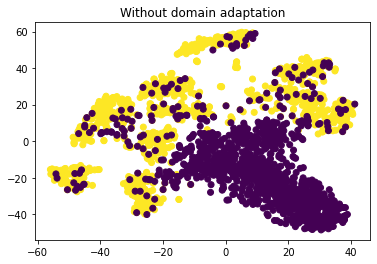

In [ ]:
source_emb = extract_emb(naive_net, source_train_loader)
target_emb = extract_emb(naive_net, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("Without domain adaptation")

Yellow dots are the source (MNIST) dataset, while purple dots are the target dataset (MNIST-M). We can clearly see that they belong to different space if we use the naive model.

Original embeddings of source / target (60000, 2352) (60000, 2352)
Samples embeddings (2000, 2352) (2000,)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


Dimension reduced embeddings (2000, 2)


Text(0.5, 1.0, 'With domain adaptation')

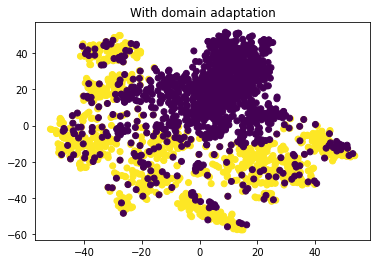

In [ ]:
source_emb = extract_emb(dann, source_train_loader)
target_emb = extract_emb(dann, target_train_loader)

print("Original embeddings of source / target", source_emb.shape, target_emb.shape)

indexes = np.random.permutation(len(source_emb))[:1000]

emb = np.concatenate((source_emb[indexes], target_emb[indexes]))
domains = np.concatenate((np.ones((1000,)), np.zeros((1000,))))

print("Samples embeddings", emb.shape, domains.shape)

tsne = TSNE(n_components=2)

emb_2d = tsne.fit_transform(emb)
print("Dimension reduced embeddings", emb_2d.shape)

plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=domains)
plt.title("With domain adaptation")

But with our DANN, while still imperfect, the two domains are much more merged. This confirm our intuition that the GRL forces the network to produce domain-agnostic features.

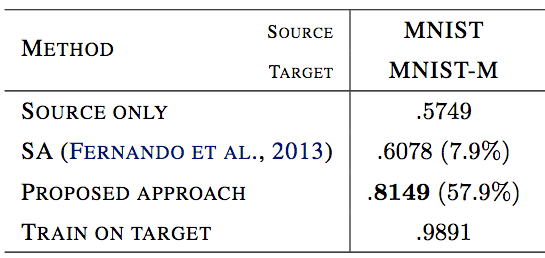

Our model is still lower than the performance reported in the original paper. You can try to further improve it by:

- use much more epochs
- modify the learning rate scheduler to be updated per step
- test different standardization
- different GRL factor scheduling